In [1]:
# Importing necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.random.set_seed(0)

In [2]:
# Generating some sample data
def generate_line(p1,p2,N=8):
    m = (p2[1] - p1[1]) / (p1[0] - p2[0])
    b = -p1[0] * m + p1[1]
    x = np.array([p1[0],p2[0]],dtype=np.float)
    y = np.array([p1[1],p2[1]],dtype=np.float)

    #add random points along the line
    xr = np.linspace(p1[0],p2[0],N, endpoint=True)
    yr = np.round(np.interp(xr, x, y),3)
    yn = yr + np.random.normal(0, 3,yr.shape[0])
    yn = np.round(yn,3)

    return [np.array([xr,yn]),np.array([xr,yr]),np.array([x,y])]

In [3]:
# define train data generator
def train_data_gen(sample=100):
    while True:
        p1 = [np.random.randint(-100,100),np.random.randint(-100,100)]
        p2 = [p1[0] + np.random.randint(10,50), p1[1] + np.random.randint(-100,100)]

        randpts = []
        lines = []
        pairs = []
        
        R,L,P = generate_line(p1,p2,sample)
        randpts.append(R)
        lines.append(L)
        pairs.append(P)
        
        yield np.array(randpts), np.array(lines),np.array(pairs)

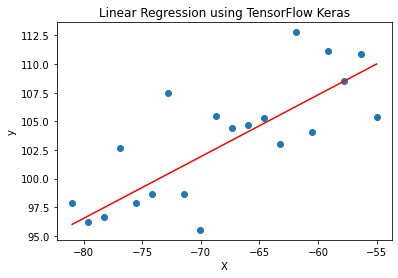

In [5]:
# plot data sample
batch_iter = train_data_gen(sample=20)
noises,lines,points = next(batch_iter)

# Plotting the results
plt.scatter(noises[0][0], noises[0][1])
plt.plot(lines[0][0], lines[0][1], color='red')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression using TensorFlow Keras')
plt.show()

In [7]:
# Create a more complex model
class PLRModel(tf.keras.Model):
    def __init__(self, shape):
        super().__init__()
        self.atten = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2)
        self.drop = tf.keras.layers.Dropout(0.01)
        self.dense1 = tf.keras.layers.Dense(32, activation="linear")
        self.dense2 = tf.keras.layers.Dense(16, activation="linear")
        self.outputs = tf.keras.layers.Dense(2)

    def call(self, inputs):
        x = self.atten(inputs,inputs)
        x = self.drop(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.outputs(x)
    
def line_loss(y_true, y_pred):
    p1_true,p2_true = y_true[:,0:1,:],y_true[:,1:2,:]
    p1_pred,p2_pred = y_pred[:,0:1,:],y_pred[:,1:2,:]
    # compute line slope
    x_true = p1_true[:,:,0] - p2_true[:,:,0]
    x_pred = p1_pred[:,:,0] - p2_pred[:,:,0]
    #m_true = tf.divide((p2_true[:,:,1] - p1_true[:,:,1]), x_true)
    #m_pred = tf.divide((p2_pred[:,:,1] - p1_pred[:,:,1]), x_pred)
    # compute vector
    v_true = p2_true - p1_true
    v_pred = p2_pred - p1_pred
    
    #compute p1,p2 and slope loss
    loss_p1 = tf.reduce_mean(tf.square(p1_true - p1_pred))
    loss_p2 = tf.reduce_mean(tf.square(p2_true - p2_pred))
    loss_v = tf.reduce_mean(tf.square(v_true - v_pred))
    #loss_a = tf.math.angle([v_true,v_pred])
    
    return  loss_p1 + loss_p2 + loss_v


In [9]:
# train model
n_sample = 20
batch_size = 32
inp_shape = (1,noises.shape[1],n_sample)
print(inp_shape)
model = PLRModel(inp_shape[1::])

# Compiling the model
model.compile(loss=line_loss, optimizer="adam", metrics=['accuracy'])
model.build(input_shape=inp_shape) 
model.summary()

epochs = 20
count = 10000
x_smaples = []
y_samples = []
iter = train_data_gen(sample=n_sample)

for i in range(count):    
    npts,lpts,pts = next(iter)
    #npts = np.reshape(np.transpose(npts),(n_sample,2))
    #pts = np.reshape(pts,(-1,4))

    x_smaples.append(npts[0])
    y_samples.append(pts[0])        
        
# split data into train and validation
split = count - (count // 4)
X_train, X_val = np.array(x_smaples[:split]), np.array(x_smaples[split:])
y_train, y_val = np.array(y_samples[:split]), np.array(y_samples[split:])
# train model
model.fit(X_train,y_train, epochs=epochs, batch_size=32, verbose=1)

(1, 2, 20)
Model: "plr_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
multi_head_attention_2 (Mult multiple                  352       
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  672       
_________________________________________________________________
dense_7 (Dense)              multiple                  528       
_________________________________________________________________
dense_8 (Dense)              multiple                  34        
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
235/235 [==============================] - 4s 11ms/step - loss: 3643.3054 - accuracy: 0.8511
Epoc

In [315]:
# Evaluate the model
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error:", mse)

79/79 [==============================] - 1s 6ms/step - loss: 1938.4348 - accuracy: 0.9620
Mean Squared Error: [1938.434814453125, 0.9620000123977661]


[[[61. 84.]
  [-3. 32.]]]
[[57.501766  72.64426  ]
 [-5.5673385 22.065296 ]]


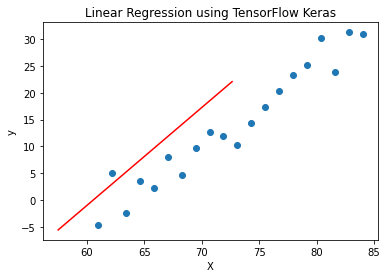

In [340]:
# Making predictions
data_iter = train_data_gen(sample=n_sample)
npts_test,_,pts_test = next(iter)
line_pred = model.predict(npts_test)
line_pred = line_pred[0]
print(pts_test)
print(line_pred)

# Plotting the results
plt.scatter(npts_test[0][0], npts_test[0][1])
plt.plot(line_pred[0],line_pred[1], color='red')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression using TensorFlow Keras')
plt.show()